In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [2]:
listings = pd.read_csv('berlin_airbnb_data/listings_summary.csv')

# Feature engineering

At first we have to delete some features based on some criteria:

1) Features that are used as identifying the owner.

2) Verbal descriptions for two reasons. Firstly, we will not be based on language recognition and secondly descriptions are covered by host_is_superhost, number of reviews, price etc.

3) Features that have NaN values over 70%


We take a look at some specific features that seem important
1) We delete interaction.
2) Concerning host_response_time,rate we see that time is categorical and informative. Therefore we delete host_response_rate


In [3]:
features_to_delete = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'city',
                     'neighborhood_overview','notes', 'transit', 'access',         #interaction
                     'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
                     'host_id', 'host_url', 'host_name','host_since', 'host_location', 'host_about',   #host_response_time and rate
                     'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
                      'host_verifications', 'street', 'state', 'market', 'smart_location', 'country_code', 
                      'country', 'calendar_updated', 'calendar_last_scraped', 'first_review', 'jurisdiction_names']

listings = listings.drop(columns = features_to_delete)

In [4]:
listings = listings.drop(columns = ['interaction', 'host_response_rate'])

By looking at the price and extra_people we see that they have the form $xx.xx, therefore we turn them into floats

Concerning security_deposit and cleaning_fee. These two seem important, therefore we will replace the NaN variables with the following:

1) The cleaning_fee will be 0.

2) Deposit seems to be quite more expensive than the rents (by looking the first 50 rows). By plotting the graph we see that this actually holds. Therefore we will pick the median of the non NaN values and fill.

In [5]:
#Clean price, extra_people

listings['price'] = listings['price'].str.replace('$','')
listings['price'] = listings['price'].str.replace(',','')
listings['extra_people'] = listings['extra_people'].str.replace('$','')
listings['extra_people'] = listings['extra_people'].str.replace(',','')
listings['price'] = listings['price'].astype(float)
listings['extra_people'] = listings['extra_people'].astype(float)

#Fill security_deposit, cleaning_fee with median

listings.loc[listings['security_deposit'].notna(), 'security_deposit'] = listings.loc[listings['security_deposit'].notna(), 'security_deposit'].str.replace('$','')
listings.loc[listings['security_deposit'].notna(), 'security_deposit'] = listings.loc[listings['security_deposit'].notna(), 'security_deposit'].str.replace(',','')
listings.loc[listings['security_deposit'].notna(), 'security_deposit'] = listings.loc[listings['security_deposit'].notna(), 'security_deposit'].astype(float)

listings.loc[listings['cleaning_fee'].notna(), 'cleaning_fee'] = listings.loc[listings['cleaning_fee'].notna(), 'cleaning_fee'].str.replace('$','')
listings.loc[listings['cleaning_fee'].notna(), 'cleaning_fee'] = listings.loc[listings['cleaning_fee'].notna(), 'cleaning_fee'].str.replace(',','')
listings.loc[listings['cleaning_fee'].notna(), 'cleaning_fee'] = listings.loc[listings['cleaning_fee'].notna(), 'cleaning_fee'].astype(float)

listings['cleaning_fee'] = listings['cleaning_fee'].fillna(0)
listings['security_deposit'] = listings['security_deposit'].fillna(listings['security_deposit'].median())

#listings['cleaning_fee'].median()

We go now to review_scores section etc. If we plot, we will see that actually a huge number of listings have very positive reviews concerning rating, cleanliness, location etc. Therefore, we proceed by fill the nan variables with the median. 

In [6]:
review_list = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
              'review_scores_checkin', 'review_scores_communication', 
               'review_scores_location', 'review_scores_value']
for column in review_list:
    listings[column] = listings[column].fillna(listings[column].median())

In [7]:
listings['host_response_time'] = listings['host_response_time'].fillna('within a few hours')  #This is actually never false! And more than a day is seldom


Finally, we see that last_review is NaN if there are no reviews. Therefore, we set nan values of review_per_month to 0 and concerning last_review we turn it into categorical with categories: review_2018, review_2017, review_before_2017, no_review




In [8]:
# replace nan reviews_per_month with 0
listings['reviews_per_month'] = listings['reviews_per_month'].fillna(0)

#build 4 categories

#First make the date format yy-mm-dd to yy. We exclude NaN because they are not lists, so lambda doesn't apply

listings.loc[listings['last_review'].notnull(), 'last_review'] = listings.loc[listings['last_review'].notnull(), 'last_review'].str.split("-").map(lambda x: x[0])

#change 2018 and 2017

listings.loc[listings['last_review'] == '2018', 'last_review'] = 'review_2018'
listings.loc[listings['last_review'] == '2017', 'last_review'] = 'review_2017'

#Turn NaN numbers to 'no_review'

listings.loc[listings.isnull()['last_review'], 'last_review'] = 'no_review'

s_1 = listings['last_review'] != 'no_review'
s_2 = listings['last_review'] != 'review_2017'
s_3 = listings['last_review'] != 'review_2018'

statement = (s_1 & s_2) & s_3

#Turn all the rest to 'review_before_2017'

listings.loc[statement, 'last_review'] = 'review_before_2017'

listings['last_review'].value_counts()

review_2018           13301
no_review              3908
review_before_2017     2709
review_2017            2634
Name: last_review, dtype: int64

Finally drop summary, neighborhood and zip code. They are covered by longitude, latitude, group_neighborhood etc

In [9]:
listings = listings.drop(columns = ['summary', 'neighbourhood', 'zipcode'])

listings = listings.loc[listings['bathrooms'].notnull() & listings['bedrooms'].notnull()]


Size seems in principle to be an important criterion. But the square_feet column is filled with NaN variables. Therefore, we will do the following:

1)Extract the square feet from the description. As we will see, we find nearly 10000 listings.

2)Consider size as a function of 'accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included'

3)Perform linear regresion to find the other missing

In [10]:
# extract numbers 
listings['size'] = listings['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
listings['size'] = listings['size'].str.replace("\D", "")

# change datatype of size into float
listings['size'] = listings['size'].astype(float)

#Now drop description

listings = listings.drop(columns = ['space', 'description'])

print(listings['size'].loc[listings['size'].notnull()].head(10))

0      75.0
1      25.0
2      68.0
3      26.0
4      20.0
5     780.0
7      55.0
8      80.0
9      25.0
14     70.0
Name: size, dtype: float64


In [11]:
# We take some variables that correlate with size

sub_listings = listings[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'size']]
# split datasets
train_data = sub_listings[sub_listings['size'].notnull()]
test_data  = sub_listings[sub_listings['size'].isnull()]

# define X
X_train = train_data.drop(columns = 'size')
X_test  = test_data.drop(columns = 'size')

# define y
y_train = train_data['size']

print(X_train.shape, X_test.shape, train_data.shape, test_data.shape, y_train.shape)

(10731, 8) (11771, 8) (10731, 9) (11771, 9) (10731,)


In [13]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

y_test = LinearRegression().fit(X_train, y_train).predict(X_test)

In [14]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']

In [15]:
#Take index of X_test i.e. 6 11 12...

prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']
prelim_index

y_test = pd.concat([y_test, prelim_index], axis=1)
y_test = y_test.set_index(['prelim'])

In [16]:
#put back the size to X_test (from which we took the size away)
new_test_data = pd.concat([X_test, y_test], axis=1)

#put this matrix to the old one. the indices will sort them selves. Finally, drop the columns
sub_listings_new = pd.concat([new_test_data, train_data], axis=0)

listings = listings.drop(columns = ['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included',  'size'])
#join the two tables

listings = pd.concat([sub_listings_new, listings], axis = 1)
listings['size']

0        75.000000
1        25.000000
2        68.000000
3        26.000000
4        20.000000
           ...    
22547    47.518267
22548    72.939015
22549    44.556716
22550    47.811977
22551    47.405301
Name: size, Length: 22502, dtype: float64

Second Part Now is One-Hot Encoding. We actually hunt the categorical variables to turn them into dummy variables.

In [17]:
cat_var_tf = ['host_is_superhost', 'host_has_profile_pic','host_identity_verified', 'is_location_exact', 'has_availability', 'requires_license', 'instant_bookable', 
              'is_business_travel_ready', 
              'require_guest_profile_picture', 'require_guest_phone_verification']    
cat_var = ['host_response_time', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 
           'bed_type', 'cancellation_policy', 'last_review']

#Now the get_dummies

for var in cat_var:    #This is done now
   listings = listings.join(pd.get_dummies(listings[var])).drop(columns = [var])

for var in cat_var_tf:
    listings = listings.join(pd.get_dummies(listings[var]).rename(columns = {'f':'f_' + var, 't':'t_' + var})).drop(columns = var)


Finally, we drop 'experience_offered' and 'amenities'. With amenities, we can be a bit more serious, f_is_business_travel_ready and t_has_availability have everywhere 0




In [18]:
listings = listings.drop(columns = ['amenities', 'experiences_offered', 'neighbourhood_cleansed',
                                   'f_is_business_travel_ready', 't_has_availability'])

Let's print how many NaN variables are remaining, and delete them since they are not important

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(listings.isnull().sum())

accommodates                              0
bathrooms                                 0
bedrooms                                  0
price                                     0
cleaning_fee                              0
security_deposit                          0
extra_people                              0
guests_included                           0
size                                      0
host_listings_count                      26
host_total_listings_count                26
latitude                                  0
longitude                                 0
beds                                     30
square_feet                           22064
weekly_price                          18844
monthly_price                         19859
minimum_nights                            0
maximum_nights                            0
availability_30                           0
availability_60                           0
availability_90                           0
availability_365                

In [20]:
listings = listings[listings.columns[listings.isnull().sum() < 13000]]
listings = listings.dropna(axis = 0)
listings = listings.astype(float)

We set a pairplot, in order to see the distribution of some features and if there exist outliers

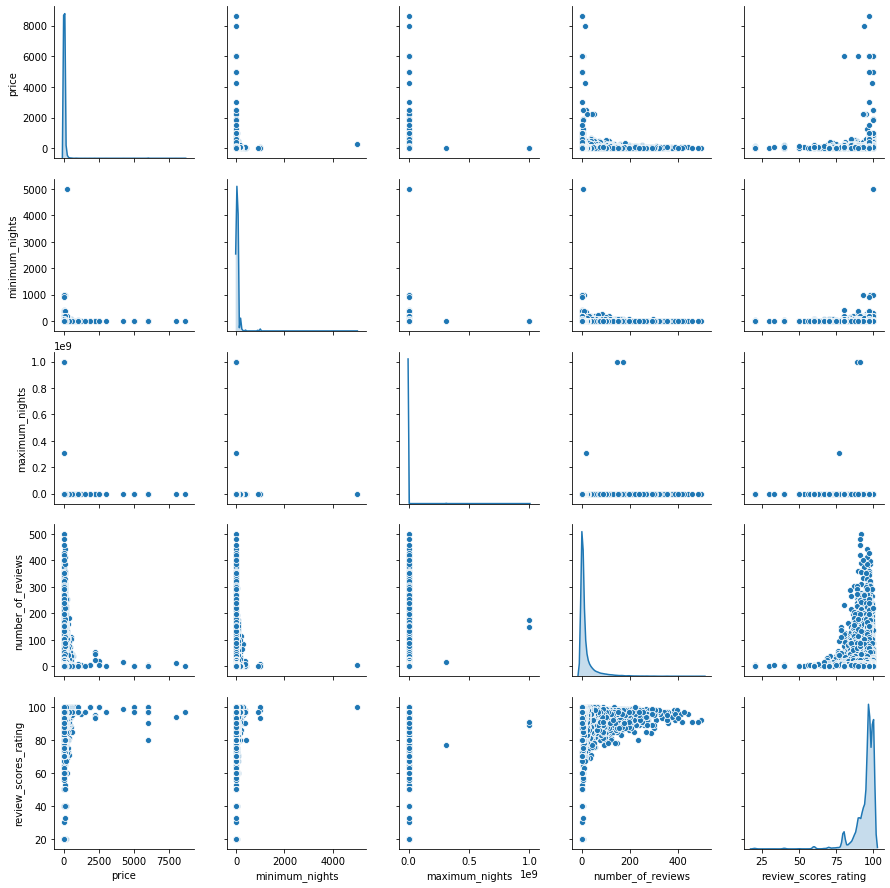

In [21]:
columns = ['price', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating']
g = sns.pairplot(listings[columns],diag_kind = 'kde')

By plotting, we notice two things:

1) The distribution of almost every variable is left-skewed. That happens due to few reasons: Firstly, a lot of outliers exist (houses with price over 5-6 thousand. Secondly, even in a normal range (0-500) more houses will tend to cost less than 100-200 rather than 200-500. So, we will keep houses with price < 500. This throws out 71 houses. We will perform a log-transform after and see how this behaves.

2) Some houses have a number of minimum_nights on the scale of over 365 days. These houses we will delete, since they seem mostly as normal apartments and airbnb is on a short-stay level. Therefore we pick houses with minimum_stay < 180 (Say almost 6 months). These are few (36). We cannot do the same with 'maximum_nights' since almost 11.000 houses have maximum_nights > 365. 

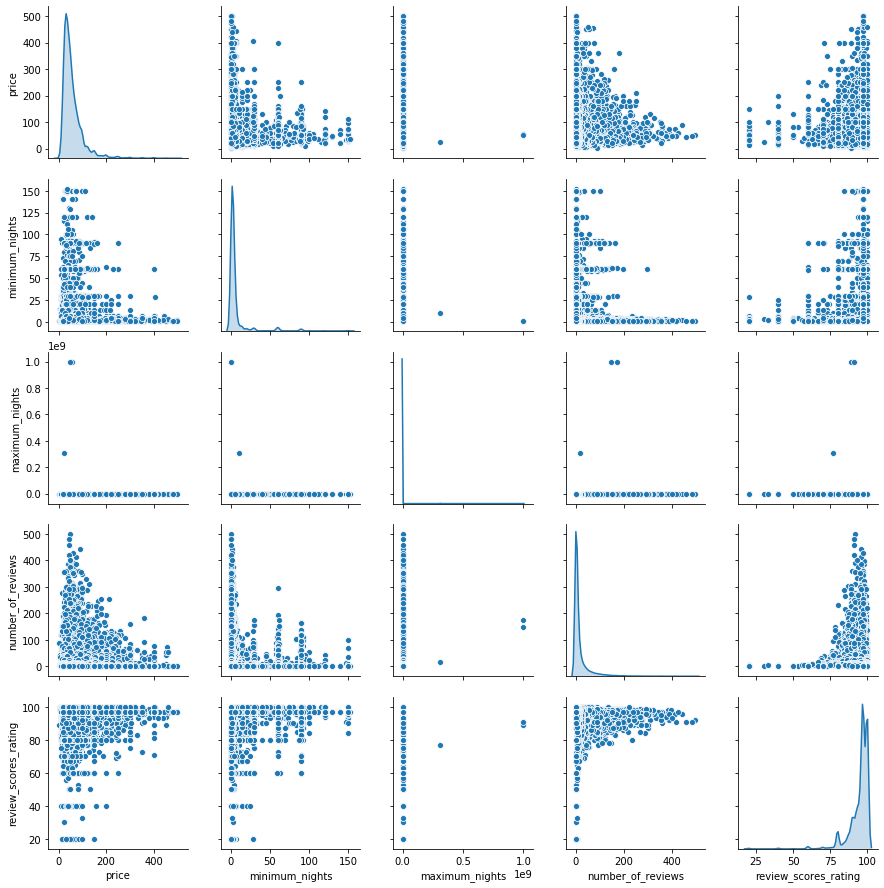

In [22]:
listings = listings.loc[listings['minimum_nights'] < 180]
listings = listings.loc[listings['price'] < 500]
listings = listings.loc[listings['price'] > 0]

g = sns.pairplot(listings[columns],diag_kind = 'kde')

#problem fixed

# Training Process

In [23]:
# Last step is to take out prices, normalize and then split into train/test/val

mean = listings.mean()        #I keep them for predictions, If I want to return to normal price
std = listings.std()

listings = (listings - mean)/std    #normalize with standardisation

y = listings['price']
listings = listings.drop(columns = 'price')  #drop price

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(listings, y, train_size = 0.70)  
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size = 0.6)

/home/dimitris/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [25]:
print(X_val.shape, X_test.shape, X_train.shape)

(2675, 111) (4011, 111) (15599, 111)


We will use now a neural network with 1 hidden layer, and perform cross-validation over the parameters 'layers', 'activation function'

In [27]:
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import losses


layers = [90, 100, 150, 200, 230, 250, 300, 350, 500]
activation_f = ['relu', 'tanh', 'sigmoid']

models = []


for layer in layers:
    for activation in activation_f:
        model = Sequential()
        model.add(Dense(layer, activation = 'sigmoid', input_dim = 111))
        model.add(Dropout(0.4))
        model.add(Dense(1))
        model.compile(optimizer = 'adam',
                      loss = losses.mean_squared_error,
                      metrics = [losses.mean_squared_error])
        model.fit(X_train, y_train,
                  validation_split = 0.1,
                  epochs = 185,
                  verbose = 0,
                  batch_size = 140)
        models.append(model)
        print('With number of layers', layer, 'and activation function', activation, 'we achieve')
        print('Train:', r2_score(y_train, model.predict(X_train)))
        print('Test:',r2_score(y_test, model.predict(X_test)), '\n')


With number of layers 90 and activation function relu we achieve
Train: 0.6749956777197694
Test: 0.5943863511292947 

With number of layers 90 and activation function tanh we achieve
Train: 0.6738184395878732
Test: 0.5924016845805782 

With number of layers 90 and activation function sigmoid we achieve
Train: 0.6765096020194554
Test: 0.5934292854404595 

With number of layers 100 and activation function relu we achieve
Train: 0.679553521740357
Test: 0.5946478977473324 

With number of layers 100 and activation function tanh we achieve
Train: 0.6785441940324416
Test: 0.5955441745054393 

With number of layers 100 and activation function sigmoid we achieve
Train: 0.6750470336132179
Test: 0.5909756883068829 

With number of layers 150 and activation function relu we achieve
Train: 0.6920054338780193
Test: 0.601197602301037 

With number of layers 150 and activation function tanh we achieve
Train: 0.6861308699182536
Test: 0.5921484643677395 

With number of layers 150 and activation functi

From this first round we see that the train/test results are stuck in the range 68-71/ 58-60 respectively when layers are more than 150. The best range is achieved when layers are between 150 and 250, mostly with relu activation function. Therefore, we can perform a second round of tuning, with these hyperparameters and also by taking into account learning rate.

In [31]:
from keras.optimizers import Adam

layers = [150, 200, 230, 250]
activation_f = ['relu', 'tanh', 'sigmoid']
learning_rates = [0.0001, 0.001, 0.005, 0.01]  #0.001 is default in Keras
epochs = [170]
models_second = []

for layer in layers:
    for activation in activation_f:
        for learning in learning_rates:
            for epoch in epochs:
                model = Sequential()
                model.add(Dense(layer, activation = 'sigmoid', input_dim = 111))
                model.add(Dropout(0.4))
                model.add(Dense(1))
                model.compile(optimizer = Adam(lr = learning),
                              loss = losses.mean_squared_error,
                              metrics = [losses.mean_squared_error])
                model.fit(X_train, y_train,
                          validation_split = 0.1,
                          epochs = epoch,
                          verbose = 0,
                          batch_size = 126)
                models_second.append(model)
                
                print('With number of layers', layer, ', activation function', activation,
                      ', learning rate', learning, 'we achieve:')
                print('Train:', r2_score(y_train, model.predict(X_train)))
                print('Test:',r2_score(y_test, model.predict(X_test)), '\n')
        
        

With number of layers 150 , activation function relu , learning rate 0.0001 we achieve:
Train: 0.534504509138241
Test: 0.5114925202791355 

With number of layers 150 , activation function relu , learning rate 0.001 we achieve:
Train: 0.6839573121230313
Test: 0.5927559200122804 

With number of layers 150 , activation function relu , learning rate 0.005 we achieve:
Train: 0.7712449867618648
Test: 0.5852579084974494 

With number of layers 150 , activation function relu , learning rate 0.01 we achieve:
Train: 0.7731807355532481
Test: 0.5715605711292095 

With number of layers 150 , activation function tanh , learning rate 0.0001 we achieve:
Train: 0.5360520441918321
Test: 0.5145180678230729 

With number of layers 150 , activation function tanh , learning rate 0.001 we achieve:
Train: 0.6857368517435516
Test: 0.5953158536119736 

With number of layers 150 , activation function tanh , learning rate 0.005 we achieve:
Train: 0.7621540915003403
Test: 0.5823271640744231 

With number of layer

We notice the following: Test score remained between 0.51-0.59. The small test score was achieved with the small learning rate of 0.0001, whereas high training score 0.7-0.8 was achieved with high learning rate (0.005-0.01). Usually very high training score (over 0.7) was resulting to test score around 0.58, whereas training score around 0.7 was resulting to test score around 0.59 (and 0.6 in the previous cell). 

The model with the highest test score is on the list models. Therefore we see how this behaves on the validation set:

In [32]:
best_model = np.argmax([r2_score(y_test, model.predict(X_test)) for model in models])
print('eval of best:', r2_score(y_val, models[best_model].predict(X_val)))

eval of best: 0.605839060568685


Validation score is 0.60, which is quite acceptable.

# Conclusions:

Looking at the training process, we see that we didn't have a big variation of test scores. Mostly we would get around 0.58-0.6. That means that further tuning will not achieve much. If we want further optimization we should either try a different model than neural network or go and do better feature engineering. Concerning the latter some directions could be:

1) Taking into account user written reviews. Actually a lot of reviews are 9/10 and 10/10 which means that this essentially didn't play any role. On the other side a very positive review can be quite crucial for the choice of the user.

2) We could identify some more parameters. For example we could calculate the distance (using longitude, latitude) to various points of interest (city center, central station). Also we could further check the amenities and break them into categories such as Wifi, Kitchen, etc. This can play a role (e.x. a place that doesn't offer Wifi nowadays cannot ask for much)